In [233]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
import numpy
from pandas.io.json import json_normalize
%matplotlib inline
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['legend.frameon'] = True

#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('deep')

In [234]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=60s' 
    return url+query+"&"+start+"&"+end+"&"+steps



In [399]:
def getCPU(start,end):
    cpuUsage = requestData(queryRangeBuilder('100-(avg%20by%20(instance,mode)%20(irate(node_cpu_seconds_total[1m]))*100)',start,end)).explode('values')
    cpuUsage = cpuUsage[cpuUsage['metric.mode'] =='idle'].drop(['metric.mode'],axis=1)
    cpuUsage['time'] = cpuUsage['values'].apply(lambda x: x[0])
    cpuUsage["host_load_average"] = cpuUsage['values'].apply(lambda x: float(x[1]))
    cpuUsage["metric.instance"] = cpuUsage['metric.instance'].apply(lambda x: x.split(":")[0])
    return cpuUsage.groupby(['time','metric.instance']).sum()

def getNetworkIn(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_receive_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkIn"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getNetworkOut(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_transmit_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkOut"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getMemory(start,end):
    memory = requestData(queryRangeBuilder('jvm_memory_pool_committed_bytes',start,end)).drop(["metric.job","metric.__name__","metric.component"],axis=1).explode('values')
    #memory = memory[memory['metric.pool'] =='shenandoah'].drop(['metric.pool'],axis=1)
    memory['time'] = memory['values'].apply(lambda x: x[0])
    memory["usedMemory"] = memory['values'].apply(lambda x: float(x[1])/1000000000)
    memory["metric.instance"] = memory['metric.instance'].apply(lambda x: x.split(":")[0])
    return memory.groupby(['time','metric.instance']).sum()

def getMailbox(start,end):
    mailbox = requestData(queryRangeBuilder("akka_group_pending_messages_sum",start,end)).explode('values').drop(['metric.job','metric.system','metric.group'],axis=1)
    mailbox['time'] = mailbox['values'].apply(lambda x: x[0])
    mailbox["mailbox"] = mailbox['values'].apply(lambda x: float(x[1]))
    mailbox["metric.instance"] = mailbox['metric.instance'].apply(lambda x: x.split(":")[0])
    return mailbox.groupby(['time','metric.instance']).sum()

def getMailboxTime(start,end):
    mailbox = requestData(queryRangeBuilder("akka_group_time_in_mailbox_seconds_sum",start,end)).explode('values').drop(['metric.job','metric.system','metric.group'],axis=1)
    mailbox['time'] = mailbox['values'].apply(lambda x: x[0])
    mailbox["mailboxTime"] = mailbox['values'].apply(lambda x: float(x[1]))
    mailbox["metric.instance"] = mailbox['metric.instance'].apply(lambda x: x.split(":")[0])
    return mailbox.groupby(['time','metric.instance']).sum()

def getGC(start,end):
    gc = requestData(queryRangeBuilder("jvm_gc_seconds_sum",start,end)).drop(["metric.job","metric.__name__","metric.component","metric.generation"],axis=1).explode('values')
    gc["metric.instance"] = gc['metric.instance'].apply(lambda x: x.split(":")[0])
    gc['time'] = gc['values'].apply(lambda x: x[0])
    gc1=gc[gc['metric.collector'] =='shenandoah-cycles'].drop(["metric.collector"],axis=1)
    gc2=gc[gc['metric.collector'] =='shenandoah-pauses'].drop(["metric.collector"],axis=1)
    gc1["cycles"] = gc1['values'].apply(lambda x: float(x[1]))
    gc2["pauses"] = gc2['values'].apply(lambda x: float(x[1]))
        
    return gc1.groupby(['time','metric.instance']).sum().join(gc2.groupby(['time','metric.instance']).sum())

def pmdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.actor']).sum()

def routerdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job","metric.__name__"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.Router']).sum()


#real plot
start = "2020-08-23T21:53:00"
end   = "2020-08-23T23:30:00"

#30GB
#start = "2020-08-28T00:45:00"
#end   = "2020-08-28T02:00:00"

#test run 64
start = "2020-08-27T08:55:00"
end   = "2020-08-27T09:23:00"

#consistent throughput 10k
#start = "2020-08-28T16:17:00"
#end   = "2020-08-28T16:55:00"

#consistent throughput 15k
#start = "2020-08-28T19:22:00"
#end   = "2020-08-28T20:50:00"

#non properties
#start = "2020-08-28T17:27:00"
#end   = "2020-08-28T18:43:00"

#checking

start = "2020-08-31T16:03:00"
end   = "2020-08-31T17:40:00"

start = "2020-08-31T20:17:00"
end   = "2020-08-31T21:02:00"

#start = "2020-09-01T10:08:00"
#end   = "2020-09-01T10:14:00"

#start = "2020-09-01T14:31:00"
#end   = "2020-09-01T15:45:00"


cpu = getCPU(start,end)
memory = getMemory(start,end)
networkIn = getNetworkIn(start,end)
networkOut = getNetworkOut(start,end)
mailbox= getMailbox(start,end)
mailboxtime = getMailboxTime(start,end)
gc = getGC(start,end)
    
def PartitionManager(start,end):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total") 
    pm = updates.join(intra).join(inter).join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()
    return pm
    
def Router(start,end):
    updates = routerdataParser(start,end,"Raphtory_Router_Output_total")
    return updates.join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()

def Spout(start,end):
    updates = pmdataParser(start,end,"Raphtory_Spout_Tuples_total")
    updates = updates.join(cpu).join(memory).join(networkIn).join(networkOut).join(mailbox).join(mailboxtime).join(gc).reset_index()
    return updates[updates['metric.instance'].str.contains(set(list(updates['metric.instance'])).pop())]


In [400]:

#pm =PartitionManager(start,end).groupby('time').sum()
router = Router(start,end).groupby('time').sum()
#spout = Spout(start,end)

pm =PartitionManager(start,end)
#router = Router(start,end)
spout = Spout(start,end)

pmCPU= list(pm['host_load_average'])
pmMem= list(pm['usedMemory'])
pmNI= list(pm['NetworkIn'])
pmNO= list(pm['NetworkOut'])
pmMailbox = list(numpy.diff(list(map((lambda x: x/60),list(pm['mailbox'])))))
pmMailboxTime = list(numpy.diff(list(map((lambda x: x/60),list(pm['mailboxTime'])))))
pmUpdates= list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Router_Updates_total'])))))
pmIntra= list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Intra_Worker_Updates_total'])))))
pmInter= list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Inter_Worker_Updates_total'])))))
pmCycles= list(numpy.diff(list(map((lambda x: x/60),list(pm['cycles'])))))
pmPauses= list(numpy.diff(list(map((lambda x: x/60),list(pm['pauses'])))))




#pmCPU= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['host_load_average'])
#pmMem= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['usedMemory'])
#pmNI= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['NetworkIn'])
#pmNO= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['NetworkOut'])
#pmMailbox = list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['mailbox'])))))
#pmMailboxTime = list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['mailboxTime'])))))
#pmUpdates= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['Raphtory_Router_Updates_total'])))))
#pmIntra= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['Raphtory_Intra_Worker_Updates_total'])))))
#pmCycles= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['cycles'])))))
#pmPauses= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['pauses'])))))


routerCPU= list(router['host_load_average'])
routerMem= list(router['usedMemory'])
routerNI= list(router['NetworkIn'])
routerNO= list(router['NetworkOut'])
routerUpdates= list(numpy.diff(list(map((lambda x: x/60),list(router['Raphtory_Router_Output_total'])))))
routerMailbox= list(numpy.diff(list(map((lambda x: x/60),list(router['mailbox'])))))
routerMailboxTime= list(numpy.diff(list(map((lambda x: x/60),list(router['mailboxTime'])))))
routerCycles= list(numpy.diff(list(map((lambda x: x/60),list(router['cycles'])))))
routerPauses= list(numpy.diff(list(map((lambda x: x/60),list(router['pauses'])))))


spoutCPU= list(spout['host_load_average'])
spoutMem= list(spout['usedMemory'])
spoutNI= list(spout['NetworkIn'])
spoutNO= list(spout['NetworkOut'])
spoutUpdates= list(numpy.diff(list(map((lambda x: x/60),list(spout['Raphtory_Spout_Tuples_total'])))))
spoutMailbox= list(numpy.diff(list(map((lambda x: x/60),list(spout['mailbox'])))))
spoutMailboxTime= list(numpy.diff(list(map((lambda x: x/60),list(spout['mailboxTime'])))))
spoutCyles= list(numpy.diff(list(map((lambda x: x/60),list(spout['cycles'])))))
spoutPauses= list(numpy.diff(list(map((lambda x: x/60),list(spout['pauses'])))))

# # f = {'Raphtory_Router_Updates_total':['sum'], 'Raphtory_Intra_Worker_Updates_total':['sum'],
#       'Raphtory_Inter_Worker_Updates_total':['sum'], 'host_load_average':['sum'],
#       'usedMemory':['sum'], 'NetworkIn':['sum'],
#       'NetworkOut':['sum'], 'host_load_average':['mean'],
#       'Raphtory_Inter_Worker_Updates_total':['sum'], 'host_load_average':['mean'],
#       'Raphtory_Inter_Worker_Updates_total':['sum'], 'host_load_average':['mean'],
#      }

# In [27]: df.groupby('GRP').agg(f)


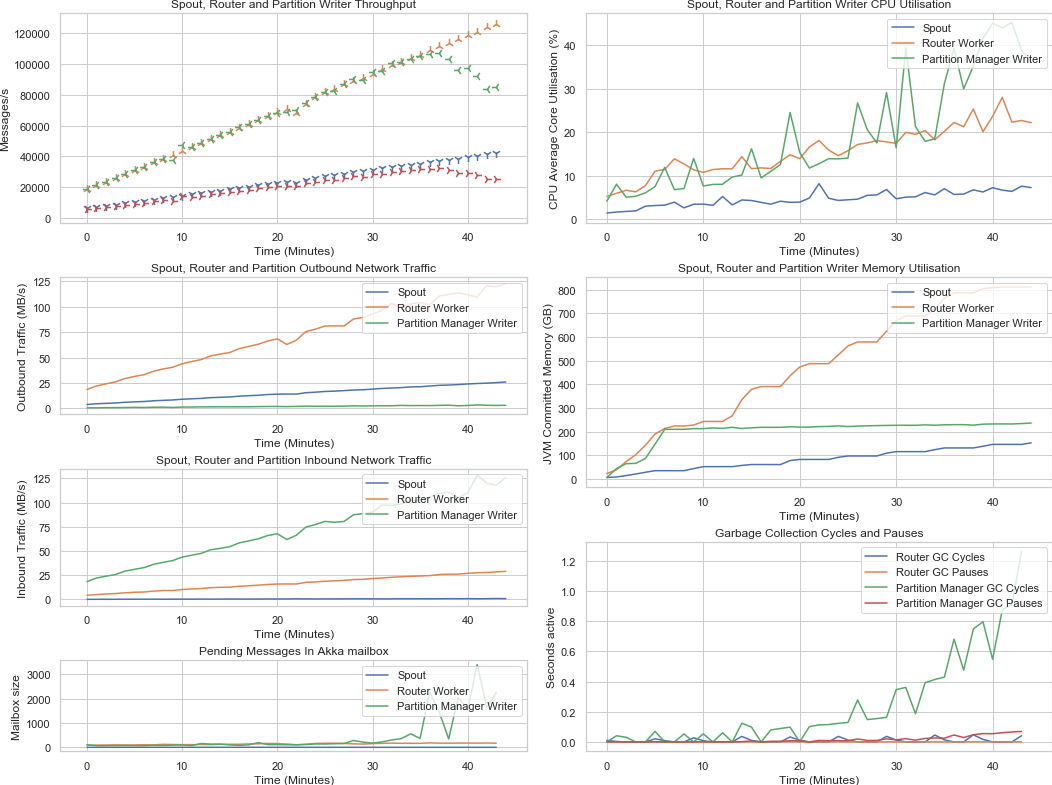

In [401]:
fig = plt.figure(constrained_layout=True,figsize=[14.7, 11])

spec = gridspec.GridSpec(ncols=2, nrows=12, figure=fig)
ax1 = fig.add_subplot(spec[0:4, 0])
ax5 = fig.add_subplot(spec[4:7, 0],sharex=ax1)
ax4 = fig.add_subplot(spec[7:10, 0],sharex=ax1)
ax6 = fig.add_subplot(spec[10:12, 0],sharex=ax1)

ax2 = fig.add_subplot(spec[0:4, 1])
ax3 = fig.add_subplot(spec[4:8, 1],sharex=ax2)
ax7 = fig.add_subplot(spec[8:12, 1],sharex=ax2)




#UPDATE THROUGHPUT
plt.setp([ax1], title='Spout, Router and Partition Writer Throughput')
plt.setp([ax1], xlabel='Time (Minutes)')
plt.setp([ax1], ylabel='Messages/s')

ax1.scatter(range(0,len(spoutUpdates)),spoutUpdates,label="Spout Output",marker="1",s=80)
ax1.scatter(range(0,len(routerUpdates)),routerUpdates,label="Router Worker Output",marker="2",s=80)
ax1.scatter(range(0,len(pmUpdates)),pmUpdates,label="Partition Manager Writer Input",marker="3",s=80)
ax1.scatter(range(0,len(pmIntra)),pmIntra,label="Partition Manager Intra Writer Synchronisation",marker="4",s=80)
#ax1.plot(range(0,len(pmInter)),pmInter,label="Partition Manager Inter Writer Synchronisation")

#ax1.legend(loc="upper left")

#MESSAGES IN MAILBOX
plt.setp([ax6], title='Pending Messages In Akka mailbox')
plt.setp([ax6], xlabel='Time (Minutes)')
plt.setp([ax6], ylabel='Mailbox size')

ax6.plot(range(0,len(spoutMailbox)),spoutMailbox,label="Spout")
ax6.plot(range(0,len(routerMailbox)),routerMailbox,label="Router Worker")
ax6.plot(range(0,len(pmMailbox)),pmMailbox,label="Partition Manager Writer")
ax6.legend(loc="upper right")

#INBOUND TRAFFIC
plt.setp([ax4], title='Spout, Router and Partition Inbound Network Traffic')
plt.setp([ax4], xlabel='Time (Minutes)')
plt.setp([ax4], ylabel='Inbound Traffic (MB/s)')

ax4.plot(range(0,len(spoutNI)),spoutNI,label="Spout")
ax4.plot(range(0,len(routerNI)),routerNI,label="Router Worker")
ax4.plot(range(0,len(pmNI)),pmNI,label="Partition Manager Writer")
ax4.legend(loc="upper right")

#OUTBOUND TRAFFIC
plt.setp([ax5], title='Spout, Router and Partition Outbound Network Traffic')
plt.setp([ax5], xlabel='Time (Minutes)')
plt.setp([ax5], ylabel='Outbound Traffic (MB/s)')

ax5.plot(range(0,len(spoutNO)),spoutNO,label="Spout")
ax5.plot(range(0,len(routerNO)),routerNO,label="Router Worker")
ax5.plot(range(0,len(pmNO)),pmNO,label="Partition Manager Writer")
ax5.legend(loc="upper right")



#CPU UTILISATION
plt.setp([ax2], title='Spout, Router and Partition Writer CPU Utilisation')
plt.setp([ax2], xlabel='Time (Minutes)')
plt.setp([ax2], ylabel='CPU Average Core Utilisation (%)')

ax2.plot(range(0,len(spoutCPU)),spoutCPU,label="Spout")
ax2.plot(range(0,len(routerCPU)),routerCPU,label="Router Worker")
ax2.plot(range(0,len(pmCPU)),pmCPU,label="Partition Manager Writer")
ax2.legend(loc="upper right")


#MEMORY UTILISATION
plt.setp([ax3], title='Spout, Router and Partition Writer Memory Utilisation')
plt.setp([ax3], xlabel='Time (Minutes)')
plt.setp([ax3], ylabel='JVM Committed Memory (GB)')


ax3.plot(range(0,len(spoutMem)),spoutMem,label="Spout")
ax3.plot(range(0,len(routerMem)),routerMem,label="Router Worker")
ax3.plot(range(0,len(pmMem)),pmMem,label="Partition Manager Writer")
ax3.legend(loc="upper right")


#GARBAGE COLLECTION
plt.setp([ax7], title='Garbage Collection Cycles and Pauses')
plt.setp([ax7], xlabel='Time (Minutes)')
plt.setp([ax7], ylabel='Seconds active')

ax7.plot(range(0,len(routerCycles)),routerCycles,label="Router GC Cycles")
ax7.plot(range(0,len(routerPauses)),routerPauses,label="Router GC Pauses")
ax7.plot(range(0,len(pmCycles)),pmCycles,label="Partition Manager GC Cycles")
ax7.plot(range(0,len(pmPauses)),pmPauses,label="Partition Manager GC Pauses")
ax7.legend(loc="upper right")



In [279]:

def PartitionManager(start,end):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    #inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total") 
    pm = updates.join(intra).reset_index()
    return pm

def getMax(pm):
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Router_Updates_total']))))))

def getMaxIntra(pm):  
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Intra_Worker_Updates_total']))))))

pm2_1 = PartitionManager("2020-08-26T18:22:07","2020-08-26T18:30:07")
pm2_2 = PartitionManager("2020-08-26T18:32:07","2020-08-26T18:41:07")
pm2_3 = PartitionManager("2020-08-26T18:50:07","2020-08-26T18:58:07")
pm2_4 = PartitionManager("2020-08-26T16:04:00","2020-08-26T16:12:00")
pm2_5 = PartitionManager("2020-08-26T16:22:00","2020-08-26T16:30:00")

maxUpdates2 = [getMax(pm2_1),getMax(pm2_2),getMax(pm2_3),getMax(pm2_4),getMax(pm2_5)]
maxIntra2 =  [getMaxIntra(pm2_1),getMaxIntra(pm2_2),getMaxIntra(pm2_3),getMaxIntra(pm2_4),getMaxIntra(pm2_5)]

pm4_1 = PartitionManager("2020-08-26T17:05:00","2020-08-26T17:17:07")
pm4_2 = PartitionManager("2020-08-26T17:19:00","2020-08-26T17:29:07")
pm4_3 = PartitionManager("2020-08-26T17:36:00","2020-08-26T17:47:07")
pm4_4 = PartitionManager("2020-08-26T17:52:00","2020-08-26T18:04:07")
pm4_5 = PartitionManager("2020-08-26T18:05:07","2020-08-26T18:16:07")

maxUpdates4 = [getMax(pm4_1),getMax(pm4_2),getMax(pm4_3),getMax(pm4_4),getMax(pm4_5)]
maxIntra4 =  [getMaxIntra(pm4_1),getMaxIntra(pm4_2),getMaxIntra(pm4_3),getMaxIntra(pm4_4),getMaxIntra(pm4_5)]

pm8_1 = PartitionManager("2020-08-26T19:07:00","2020-08-26T19:23:00")
pm8_2 = PartitionManager("2020-08-26T19:26:00","2020-08-26T19:43:00")
pm8_3 = PartitionManager("2020-08-26T19:45:00","2020-08-26T20:02:00")
pm8_4 = PartitionManager("2020-08-26T20:04:00","2020-08-26T20:22:00")
pm8_5 = PartitionManager("2020-08-26T20:29:00","2020-08-26T20:46:00")

maxUpdates8 = [getMax(pm8_1),getMax(pm8_2),getMax(pm8_3),getMax(pm8_4),getMax(pm8_5)]
maxIntra8 =  [getMaxIntra(pm8_1),getMaxIntra(pm8_2),getMaxIntra(pm8_3),getMaxIntra(pm8_4),getMaxIntra(pm8_5)]

pm8r_1 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")
pm8r_2 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")
pm8r_3 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")
pm8r_4 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")
pm8r_5 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")

maxUpdates8r = [getMax(pm8r_1),getMax(pm8r_2),getMax(pm8r_3),getMax(pm8r_4),getMax(pm8r_5)]
maxIntra8r =  [getMaxIntra(pm8r_1),getMaxIntra(pm8r_2),getMaxIntra(pm8r_3),getMaxIntra(pm8r_4),getMaxIntra(pm8r_5)]

pm16_1 = PartitionManager("2020-08-26T20:57:00","2020-08-26T21:16:00")
pm16_2 = PartitionManager("2020-08-26T21:23:00","2020-08-26T21:41:00")
pm16_3 = PartitionManager("2020-08-26T21:44:00","2020-08-26T22:03:00")
pm16_4 = PartitionManager("2020-08-26T22:10:00","2020-08-26T22:28:00")
pm16_5 = PartitionManager("2020-08-26T22:31:00","2020-08-26T22:52:00")

maxUpdates16 = [getMax(pm16_1),getMax(pm16_2),getMax(pm16_3),getMax(pm16_4),getMax(pm16_5)]
maxIntra16 =  [getMaxIntra(pm16_1),getMaxIntra(pm16_2),getMaxIntra(pm16_3),getMaxIntra(pm16_4),getMaxIntra(pm16_5)]

pm32_1 = PartitionManager("2020-08-26T23:02:00","2020-08-26T23:21:00")
pm32_2 = PartitionManager("2020-08-26T23:23:00","2020-08-26T23:50:00")
pm32_3 = PartitionManager("2020-08-26T23:55:00","2020-08-27T00:22:00")
pm32_4 = PartitionManager("2020-08-27T00:25:00","2020-08-27T00:53:00")
pm32_5 = PartitionManager("2020-08-27T00:57:00","2020-08-27T01:24:00")

maxUpdates32 = [getMax(pm32_1),getMax(pm32_2),getMax(pm32_3),getMax(pm32_4),getMax(pm32_5)]
maxIntra32 =  [getMaxIntra(pm32_1),getMaxIntra(pm32_2),getMaxIntra(pm32_3),getMaxIntra(pm32_4),getMaxIntra(pm32_5)]

pm64_1 = PartitionManager("2020-08-27T08:55:00","2020-08-27T09:23:00")
pm64_2 = PartitionManager("2020-08-27T09:27:00","2020-08-27T09:54:00")
pm64_3 = PartitionManager("2020-08-27T09:58:00","2020-08-27T10:26:00")
pm64_4 = PartitionManager("2020-08-27T10:28:00","2020-08-27T10:57:00")
pm64_5 = PartitionManager("2020-08-27T11:00:00","2020-08-27T11:27:00")

maxUpdates64 = [getMax(pm64_1),getMax(pm64_2),getMax(pm64_3),getMax(pm64_4),getMax(pm64_5)]
maxIntra64 =  [getMaxIntra(pm64_1),getMaxIntra(pm64_2),getMaxIntra(pm64_3),getMaxIntra(pm64_4),getMaxIntra(pm64_5)]



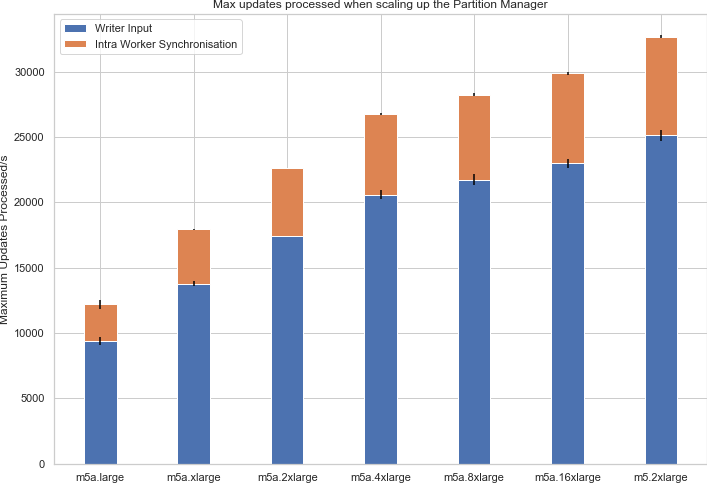

In [178]:
N = 7
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
updateMeans = (numpy.mean(maxUpdates2),numpy.mean(maxUpdates4),numpy.mean(maxUpdates8r),numpy.mean(maxUpdates16),numpy.mean(maxUpdates32),numpy.mean(maxUpdates64),numpy.mean(maxUpdates8))
intraMeans = (numpy.mean(maxIntra2),numpy.mean(maxIntra4),numpy.mean(maxIntra8r),numpy.mean(maxIntra16),numpy.mean(maxIntra32),numpy.mean(maxIntra64),numpy.mean(maxIntra8))
updateStd = (numpy.std(maxUpdates2),numpy.std(maxUpdates4),numpy.std(maxUpdates8r),numpy.std(maxUpdates16),numpy.std(maxUpdates32),numpy.std(maxUpdates64),numpy.std(maxUpdates8))
intraStd = (numpy.std(maxUpdates2),numpy.std(maxIntra4),numpy.std(maxIntra8r),numpy.std(maxIntra16),numpy.std(maxIntra32),numpy.std(maxIntra64),numpy.std(maxIntra8))
ind = numpy.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, updateMeans, width, yerr=updateStd)
p2 = plt.bar(ind, intraMeans, width,
             bottom=updateMeans, yerr=intraStd)

plt.ylabel('Maximum Updates Processed/s')
plt.title('Max updates processed when scaling up the Partition Manager')
plt.xticks(ind, ('m5a.large', 'm5a.xlarge', 'm5a.2xlarge', 'm5a.4xlarge', 'm5a.8xlarge', 'm5a.16xlarge', 'm5.2xlarge'))
plt.legend((p1[0], p2[0]), ('Writer Input', 'Intra Worker Synchronisation'))
plt.show()

In [265]:

def PartitionManager(start,end):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    #inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total") 
    pm = updates.join(intra).reset_index()
    return pm

def getMax(pm):
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Router_Updates_total']))))))

def getMaxIntra(pm):  
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Intra_Worker_Updates_total']))))))

def buildList(label,pm1,pm2,pm3,pm4,pm5):
    return [[label,'Writer Input',getMax(pm1)],[label,'Writer Input',getMax(pm2)],
     [label,'Writer Input',getMax(pm3)],[label,'Writer Input',getMax(pm4)],
     [label,'Writer Input',getMax(pm5)],['m5a.large','Intra Worker Synchronisation',getMaxIntra(pm1)],
     [label,'Intra Worker Synchronisation',getMaxIntra(pm2)],[label,'Intra Worker Synchronisation',getMaxIntra(pm3)],
     [label,'Intra Worker Synchronisation',getMaxIntra(pm4)],[label,'Intra Worker Synchronisation',getMaxIntra(pm5)]]

pm2_1 = PartitionManager("2020-08-26T18:22:07","2020-08-26T18:30:07")
pm2_2 = PartitionManager("2020-08-26T18:32:07","2020-08-26T18:41:07")
pm2_3 = PartitionManager("2020-08-26T18:50:07","2020-08-26T18:58:07")
pm2_4 = PartitionManager("2020-08-26T16:04:00","2020-08-26T16:12:00")
pm2_5 = PartitionManager("2020-08-26T16:22:00","2020-08-26T16:30:00")

pm4_1 = PartitionManager("2020-08-26T17:05:00","2020-08-26T17:17:07")
pm4_2 = PartitionManager("2020-08-26T17:19:00","2020-08-26T17:29:07")
pm4_3 = PartitionManager("2020-08-26T17:36:00","2020-08-26T17:47:07")
pm4_4 = PartitionManager("2020-08-26T17:52:00","2020-08-26T18:04:07")
pm4_5 = PartitionManager("2020-08-26T18:05:07","2020-08-26T18:16:07")

pm8_1 = PartitionManager("2020-08-27T21:05:00","2020-08-27T21:25:00")
pm8_2 = PartitionManager("2020-08-27T21:37:00","2020-08-27T21:57:00")
pm8_3 = PartitionManager("2020-08-27T22:07:00","2020-08-27T22:28:00")
pm8_4 = PartitionManager("2020-08-27T22:40:00","2020-08-27T22:58:00")
pm8_5 = PartitionManager("2020-08-27T23:11:00","2020-08-27T23:29:00")

pm16_1 = PartitionManager("2020-08-26T20:57:00","2020-08-26T21:16:00")
pm16_2 = PartitionManager("2020-08-26T21:23:00","2020-08-26T21:41:00")
pm16_3 = PartitionManager("2020-08-26T21:44:00","2020-08-26T22:03:00")
pm16_4 = PartitionManager("2020-08-26T22:10:00","2020-08-26T22:28:00")
pm16_5 = PartitionManager("2020-08-26T22:31:00","2020-08-26T22:52:00")

pm32_1 = PartitionManager("2020-08-26T23:02:00","2020-08-26T23:21:00")
pm32_2 = PartitionManager("2020-08-26T23:23:00","2020-08-26T23:50:00")
pm32_3 = PartitionManager("2020-08-26T23:55:00","2020-08-27T00:22:00")
pm32_4 = PartitionManager("2020-08-27T00:25:00","2020-08-27T00:53:00")
pm32_5 = PartitionManager("2020-08-27T00:57:00","2020-08-27T01:24:00")

pm64_1 = PartitionManager("2020-08-27T08:55:00","2020-08-27T09:23:00")
pm64_2 = PartitionManager("2020-08-27T09:27:00","2020-08-27T09:54:00")
pm64_3 = PartitionManager("2020-08-27T09:58:00","2020-08-27T10:26:00")
pm64_4 = PartitionManager("2020-08-27T10:28:00","2020-08-27T10:57:00")
pm64_5 = PartitionManager("2020-08-27T11:00:00","2020-08-27T11:27:00")

pm2=buildList('m5a.large',pm2_1,pm2_2,pm2_3,pm2_4,pm2_5)
pm4=buildList('m5a.xlarge',pm4_1,pm4_2,pm4_3,pm4_4,pm4_5)
pm8=buildList('m5a.2xlarge',pm8_1,pm8_2,pm8_3,pm8_4,pm8_5)
pm16=buildList('m5a.4xlarge',pm16_1,pm16_2,pm16_3,pm16_4,pm16_5)
pm32=buildList('m5a.8xlarge',pm32_1,pm32_2,pm32_3,pm32_4,pm32_5)
pm64=buildList('m5a.16xlarge',pm64_1,pm64_2,pm64_3,pm64_4,pm64_5)





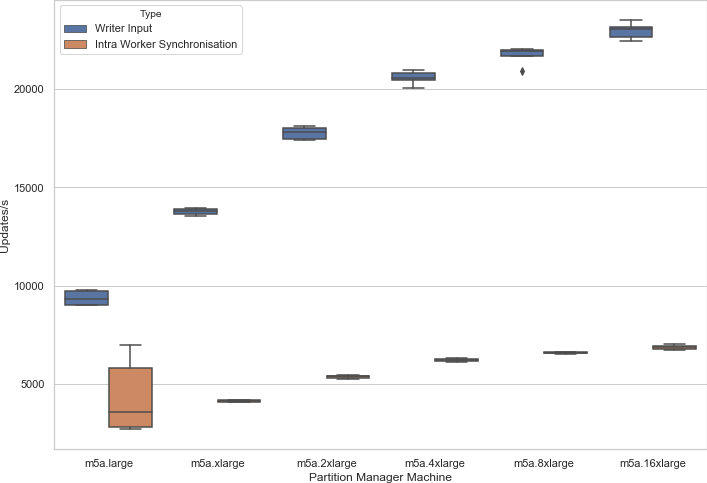

In [267]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
df = pd.DataFrame(pm2+pm4+pm8+pm16+pm32+pm64, columns =['Partition Manager Machine', 'Type', 'Updates/s'], dtype = float) 
ax = sns.boxplot(x='Partition Manager Machine', y='Updates/s', hue='Type',
                 data=df)#, palette="Set3")

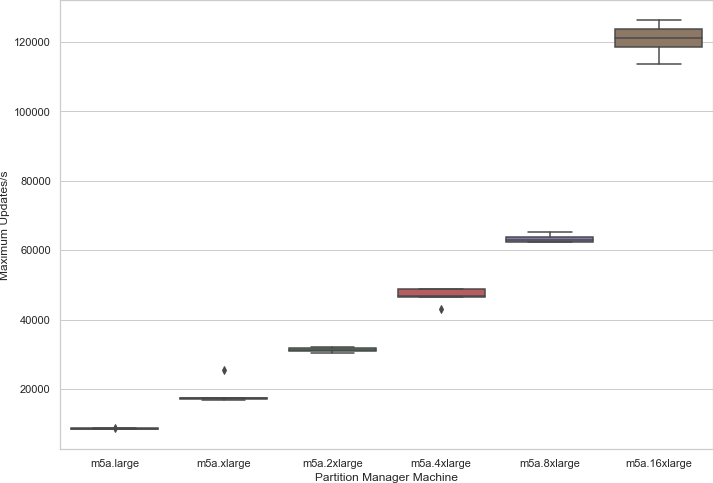

In [398]:

#pm32_1 = PartitionManager("2020-09-01T18:11:07","2020-09-01T18:17:07")
#pm32_2 = PartitionManager("2020-09-01T18:26:07","2020-09-01T18:34:07")
#pm32_3 = PartitionManager("2020-09-01T18:53:07","2020-09-01T19:01:07")
#pm32_4 = PartitionManager("2020-09-01T19:32:07","2020-09-01T19:40:07")
#pm32_5 = PartitionManager("2020-09-01T19:48:07","2020-09-01T19:56:07")

def PartitionManager(start,end):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    #inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total") 
    pm = updates.join(intra).reset_index()
    return pm

def getMax(pm):
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Router_Updates_total']))))))

def getMaxIntra(pm):  
    return max(list(numpy.diff(list(map((lambda x: x/60),list(pm['Raphtory_Intra_Worker_Updates_total']))))))

def buildList(label,pm1,pm2,pm3,pm4,pm5):
    return [[label,'Writer Input',getMax(pm1)],[label,'Writer Input',getMax(pm2)],
     [label,'Writer Input',getMax(pm3)],[label,'Writer Input',getMax(pm4)],
     [label,'Writer Input',getMax(pm5)]]


pm2_1 = PartitionManager("2020-09-01T10:50:07","2020-09-01T10:58:07")
pm2_2 = PartitionManager("2020-09-01T11:19:07","2020-09-01T11:27:07")
pm2_3 = PartitionManager("2020-09-01T12:21:07","2020-09-01T12:29:07")
pm2_4 = PartitionManager("2020-09-01T12:51:07","2020-09-01T12:59:07")
pm2_5 = PartitionManager("2020-09-01T14:09:07","2020-09-01T14:17:07")

pm4_1 = PartitionManager("2020-09-02T00:00:07","2020-09-02T00:06:07")
pm4_2 = PartitionManager("2020-09-02T00:09:07","2020-09-02T00:15:07")
pm4_3 = PartitionManager("2020-09-02T00:17:07","2020-09-02T00:24:07")
pm4_4 = PartitionManager("2020-09-02T00:27:07","2020-09-02T00:34:07")
pm4_5 = PartitionManager("2020-09-02T00:41:07","2020-09-02T00:48:07")

pm8_1 = PartitionManager("2020-09-01T22:54:07","2020-09-01T23:02:07")
pm8_2 = PartitionManager("2020-09-01T23:08:07","2020-09-01T23:15:07")
pm8_3 = PartitionManager("2020-09-01T23:20:07","2020-09-01T23:27:07")
pm8_4 = PartitionManager("2020-09-01T23:33:07","2020-09-01T23:40:07")
pm8_5 = PartitionManager("2020-09-01T23:45:07","2020-09-01T23:51:07")

pm16_1 = PartitionManager("2020-09-01T20:04:07","2020-09-01T20:14:07")
pm16_2 = PartitionManager("2020-09-01T21:52:07","2020-09-01T22:04:07")
pm16_3 = PartitionManager("2020-09-01T22:10:07","2020-09-01T22:20:07")
pm16_4 = PartitionManager("2020-09-01T22:24:07","2020-09-01T22:33:07")
pm16_5 = PartitionManager("2020-09-01T22:39:07","2020-09-01T22:51:07")

pm32_1 = PartitionManager("2020-09-01T20:19:07","2020-09-01T20:34:07")
pm32_2 = PartitionManager("2020-09-01T20:38:07","2020-09-01T20:50:07")
pm32_3 = PartitionManager("2020-09-01T21:11:07","2020-09-01T21:22:07")
pm32_4 = PartitionManager("2020-09-01T21:24:07","2020-09-01T21:34:07")
pm32_5 = PartitionManager("2020-09-01T21:36:07","2020-09-01T21:48:07")

pm64_1 = PartitionManager("2020-09-01T17:48:07","2020-09-01T18:04:07")
pm64_2 = PartitionManager("2020-09-01T17:29:07","2020-09-01T17:44:07")
pm64_3 = PartitionManager("2020-09-01T17:13:07","2020-09-01T17:26:07")
pm64_4 = PartitionManager("2020-09-01T16:39:07","2020-09-01T16:55:07")
pm64_5 = PartitionManager("2020-09-01T16:21:07","2020-09-01T16:34:07")



pm2=buildList('m5a.large',pm2_1,pm2_2,pm2_3,pm2_4,pm2_5)
pm4=buildList('m5a.xlarge',pm4_1,pm4_2,pm4_3,pm4_4,pm4_5)
pm8=buildList('m5a.2xlarge',pm8_1,pm8_2,pm8_3,pm8_4,pm8_5)
pm16=buildList('m5a.4xlarge',pm16_1,pm16_2,pm16_3,pm16_4,pm16_5)
pm32=buildList('m5a.8xlarge',pm32_1,pm32_2,pm32_3,pm32_4,pm32_5)
pm64=buildList('m5a.16xlarge',pm64_1,pm64_2,pm64_3,pm64_4,pm64_5)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11.7, 8.27)
df = pd.DataFrame(pm2+pm4+pm8+pm16+pm32+pm64, columns =['Partition Manager Machine', 'Type', 'Maximum Updates/s'], dtype = float) 
ax = sns.boxplot(x='Partition Manager Machine', y='Maximum Updates/s',data=df)#, palette="Set3")